In [0]:
#Worked together with jef008 - Sander Berge

#if you don't have pytorch installed:
#!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [0]:
BATCH_SIZE = 100

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.FashionMNIST(root='', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.FashionMNIST(root='', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [36]:
#show dimensions
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([100, 1, 28, 28])
Image label dimensions: torch.Size([100])


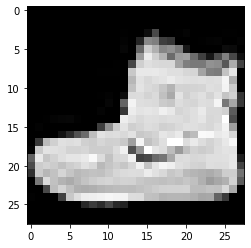

In [37]:
#show an image
import matplotlib.pyplot as plt
plt.imshow(trainset[0][0][0], cmap="gray")
plt.show()

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        self.d1 = nn.Linear(3 * 3 * 128, 256)
        self.d2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = x.flatten(start_dim = 1)

        x = self.d1(x)
        x = F.relu(x)

        x = self.d2(x)
        out = F.softmax(x, dim=1)
        return out

In [39]:
## test the model with 1 batch
net = Net()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = net(images)
    print(out.shape)
    break

batch size: torch.Size([100, 1, 28, 28])
torch.Size([100, 10])


In [0]:
learning_rate = 0.001
num_epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

#accuracy
def get_accuracy(pred, target, batch_size):
    corrects = (torch.max(pred, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [41]:
import sklearn.metrics as sk
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    net = net.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)


        ## forward + backprop + loss
        logits = net(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    net.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i)) 

Epoch: 0 | Loss: 1.8087 | Train Accuracy: 65.88
Epoch: 1 | Loss: 1.7247 | Train Accuracy: 74.05
Epoch: 2 | Loss: 1.7008 | Train Accuracy: 76.34
Epoch: 3 | Loss: 1.6251 | Train Accuracy: 84.02
Epoch: 4 | Loss: 1.5802 | Train Accuracy: 88.56
Epoch: 5 | Loss: 1.5716 | Train Accuracy: 89.42
Epoch: 6 | Loss: 1.5667 | Train Accuracy: 89.87
Epoch: 7 | Loss: 1.5611 | Train Accuracy: 90.40
Epoch: 8 | Loss: 1.5555 | Train Accuracy: 91.00
Epoch: 9 | Loss: 1.5522 | Train Accuracy: 91.33


In [42]:
## test step
import numpy as np
test_acc = 0.0
np_labels = np.array([])
np_pred = np.array([])
with torch.no_grad():
  for i, (images, labels) in enumerate(testloader):
      
      images = images.to(device)
      labels = labels.to(device)

      logits = net(images)

      np_labels = np.append(np_labels, labels.cpu().numpy())
      np_pred = np.append(np_pred, logits.max(1)[1].cpu().numpy())

      test_acc += get_accuracy(logits, labels, BATCH_SIZE)

print('Test Accuracy: %.2f' \
      %(test_acc/i)) 

conf_matrix = sk.confusion_matrix(np_labels, np_pred)

Test Accuracy: 90.98


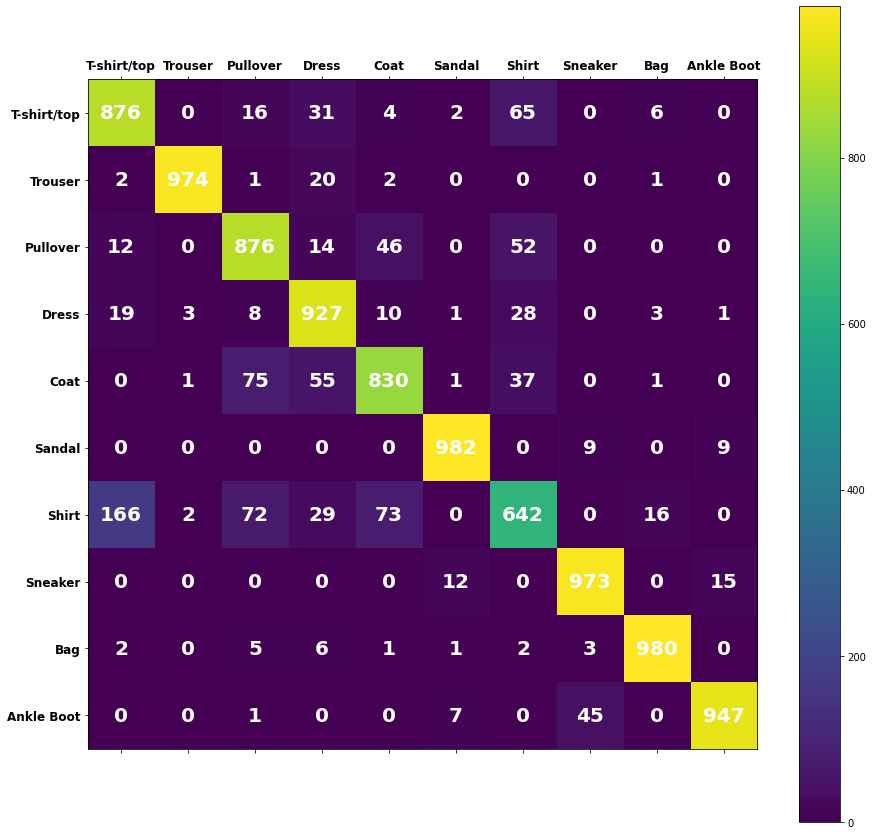

In [43]:
#Plot
import matplotlib.pyplot as plt
class_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
cax = ax.matshow(conf_matrix, interpolation='nearest')
fig.colorbar(cax)

ax.set_xticklabels(class_labels, {"fontweight":"bold", "fontsize":"12"})
ax.set_yticklabels(class_labels, {"fontweight":"bold", "fontsize":"12"})

start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, 10, 1))
ax.yaxis.set_ticks(np.arange(0, 10, 1))

for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        text = ax.text(j, i, conf_matrix[i, j],
                       ha="center", va="center", color="w", fontweight="bold", fontsize=20)
plt.show()

In [44]:
torch.save(net, "trained_cnn_model.pt")


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
from google.colab import files
files.download("trained_cnn_model.pt")